# 读取数据

In [1]:
from scipy.io import loadmat

# 读取Person数据
OSPerson_dict = {}
rawTracePerson_dict = {}
for i in range(1, 5):
    OSPerson_dict[f'OSPerson{i}'] = loadmat(f'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\人Task2数据整理\\Person{i}\\Person{i}\\OSPerson{i}.mat')
    rawTracePerson_dict[f'rawTracePerson{i}'] = loadmat(f'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\人Task2数据整理\\Person{i}\\Person{i}\\rawTracePerson{i}.mat')

# 读取其他数据
ChanName = loadmat('C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\人Task2数据整理\\ChanName.mat')
Pair54 = loadmat('C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\人Task2数据整理\\Pair54.mat')
timeRawTrace = loadmat('C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\人Task2数据整理\\timeRawTrace.mat')


# 打印数据

In [2]:
print(OSPerson_dict['OSPerson1']['OS'].shape)
print(OSPerson_dict[f'OSPerson1']['OS'][-21:-5, 4:13, :, :].shape)
print(OSPerson_dict['OSPerson1']['fOS'])

(36, 52, 40, 54)
(16, 9, 40, 54)
[[  3.0713716 ]
 [  3.29181458]
 [  3.52807951]
 [  3.78130199]
 [  4.05269913]
 [  4.34357537]
 [  4.65532882]
 [  4.98945789]
 [  5.34756856]
 [  5.73138207]
 [  6.1427432 ]
 [  6.58362915]
 [  7.05615901]
 [  7.56260398]
 [  8.10539825]
 [  8.68715075]
 [  9.31065764]
 [  9.97891578]
 [ 10.69513711]
 [ 11.46276414]
 [ 12.28548641]
 [ 13.16725831]
 [ 14.11231803]
 [ 15.12520796]
 [ 16.2107965 ]
 [ 17.3743015 ]
 [ 18.62131528]
 [ 19.95783155]
 [ 21.39027423]
 [ 22.92552827]
 [ 24.57097282]
 [ 26.33451661]
 [ 28.22463605]
 [ 30.25041591]
 [ 32.42159301]
 [ 34.748603  ]
 [ 37.24263055]
 [ 39.9156631 ]
 [ 42.78054845]
 [ 45.85105654]
 [ 49.14194563]
 [ 52.66903322]
 [ 56.44927211]
 [ 60.50083182]
 [ 64.84318601]
 [ 69.49720599]
 [ 74.4852611 ]
 [ 79.8313262 ]
 [ 85.5610969 ]
 [ 91.70211308]
 [ 98.28389126]
 [105.33806645]]


# 导入确定性pytorch神经网络框架&CUDA

In [3]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 或者 ':16:8'

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

class MyCustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature_tensor = torch.tensor(self.features[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature_tensor, label_tensor

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(MyNeuralNetwork, self).__init__()
        # 定义网络层
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size, num_classes)
        # 应用权重初始化
        self.apply(init_weights)

    def forward(self, x):
        # 定义前向传播
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

In [4]:
# 检查CUDA是否可用
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available. Running on CPU instead.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!


# 设置随机种子

In [5]:
torch.manual_seed(42)  # 设置CPU生成随机数的种子

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)  # 设置GPU生成随机数的种子
    torch.cuda.manual_seed_all(42)  # 设置所有GPU的随机种子

import numpy as np
np.random.seed(42)  # 设置NumPy生成随机数的种子

import random
random.seed(42)  # 设置Python内建random库的种子

torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = False

# 1. 分类任务

## 1. 多分类

In [28]:
from sklearn.model_selection import train_test_split

####  0. 统计图片

In [ ]:
print(OSPerson_dict['OSPerson1']['Track'][0])
print(OSPerson_dict['OSPerson2']['Track'][0])
print(OSPerson_dict['OSPerson3']['Track'][0])
print(OSPerson_dict['OSPerson4']['Track'][0])
track_list = np.concatenate(
    (OSPerson_dict['OSPerson1']['Track'][0], 
    OSPerson_dict['OSPerson2']['Track'][0], 
    OSPerson_dict['OSPerson3']['Track'][0], 
    OSPerson_dict['OSPerson4']['Track'][0]), 
    axis = 0
)
from collections import Counter
count = Counter(track_list)
print(count)
good_list = {5:1, 2:2, 10:3, 8:4, 18:5, 12:6, 9:7, 13:8, 7:9}
reversed_good_list = {value: key for key, value in good_list.items()}

### 1. 3秒，全通道, 20Hz+
#### 1. 数据处理

In [ ]:
# 数据预处理
data_reshaped_all_1_1 = np.zeros((0, 20736))
# 16x24x54 =20736
labels_all_1_1 = np.array([])
for i in range(1, 5):
    data_1_1 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 28:, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_1_1 = np.transpose(data_1_1, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_1_1 = data_transposed_1_1.reshape(data_transposed_1_1.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_1_1.shape)
    
    data_reshaped_all_1_1 = np.concatenate((data_reshaped_all_1_1, data_reshaped_1_1), axis=0)
    print(data_reshaped_all_1_1.shape)
    
    # 创建标签数组x
    labels_1_1 = np.array([good_list[x] if x in good_list else 0 for x in OSPerson_dict[f'OSPerson{i}']['Track'][0]])
    labels_all_1_1 = np.concatenate((labels_all_1_1, labels_1_1), axis=0)
    print(labels_all_1_1.shape)

labels_all_1_1 = labels_all_1_1.astype(np.int32, copy=False)

train_features, test_features, train_labels, test_labels = train_test_split(
    data_reshaped_all_1_1, labels_all_1_1, test_size = 0.2, random_state = 42, stratify = labels_all_1_1
)

#### 训练模型
##### 1. 网格搜索最优参数

In [ ]:
train_dataset_1_1 = MyCustomDataset(train_features, train_labels)

test_dataset_1_1 = MyCustomDataset(test_features, test_labels)
test_loader_1_1 = DataLoader(test_dataset_1_1, batch_size = 20, shuffle = False)

# 初始化网络
input_size_1_1 = 20736 # 特征数量
num_classes_1_1 = 10 # 类别数量


# 定义参数网格
param_grid_1_1 = {
    'lr': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
    'hidden_size': [128, 256, 512, 1024],
    'batch_size': [10, 20, 30, 40, 50],
    'num_epochs': [3, 5, 7, 9], # 训练的轮数
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'weight_decay': [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
}

# 用于记录最佳验证损失
best_loss = float('inf')
best_params = {}

# 网格搜索
for lr in param_grid_1_1['lr']:
    for hidden_size in param_grid_1_1['hidden_size']:
        for batch_size in param_grid_1_1['batch_size']:
            for num_epochs in param_grid_1_1['num_epochs']:
                for dropout_rate in param_grid_1_1['dropout_rate']:
                    for weight_decay in param_grid_1_1['weight_decay']:
                        print(
                            f'Testing with lr = {lr},'
                            f'hidden_size = {hidden_size},'
                            f'batch_size = {batch_size},'
                            f'num_epochs = {num_epochs},'
                            f'dropout_rate = {dropout_rate},'
                            f'weight_decay = {weight_decay}'
                        )
                        
                        # 初始化网络、损失函数、优化器、加载训练数据
                        model = MyNeuralNetwork(input_size_1_1, hidden_size, num_classes_1_1, dropout_rate).to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
                        train_loader_1_1 = DataLoader(train_dataset_1_1, batch_size = batch_size, shuffle = False)
            
                        # 训练网络
                        for epoch in range(num_epochs):
                            for features, labels in train_loader_1_1:
                                features, labels = features.to(device), labels.to(device)
                                # 清空梯度
                                optimizer.zero_grad()
                                # 前向传播
                                outputs = model(features)
                                # 计算损失
                                loss = criterion(outputs, labels)
                                # 反向传播
                                loss.backward()
                                # 更新权重
                                optimizer.step()
                            print(f"Epoch[{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
            
                        # 评估模型
                        model.eval()
                        val_loss = 0.0
                        with torch.no_grad():
                            for features, labels in test_loader_1_1:
                                features, labels = features.to(device), labels.to(device)
                                outputs = model(features)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
            
                        # 记录最佳参数
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_params = {
                                'lr': lr, 
                                'hidden_size': hidden_size, 
                                'batch_size': batch_size, 
                                'num_epochs': num_epochs, 
                                'dropout_rate': dropout_rate, 
                                'weight_decay': weight_decay
                            }
                            print(f"New best params: {best_params}")

print(f"Best loss: {best_loss} with params: {best_params}")

##### 2. 训练评估模型

In [ ]:
# 使用最佳参数重新训练模型
best_lr = best_params['lr']
best_hidden_size = best_params['hidden_size']
best_batch_size = best_params['batch_size']
best_num_epochs = best_params['num_epochs']
best_dropout_rate = best_params['dropout_rate']
best_weight_decay = best_params['weight_decay']

best_accuracy = 0
for i in range(1000):
    # 重新初始化网络、损失函数、优化器
    model_1_1 = MyNeuralNetwork(input_size_1_1, best_hidden_size, num_classes_1_1, best_dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_1_1.parameters(), lr = best_lr, weight_decay = best_weight_decay)

    # 使用最佳批量大小更新 DataLoader
    train_loader_1_1 = DataLoader(train_dataset_1_1, batch_size = best_batch_size, shuffle = False)
    test_loader_1_1 = DataLoader(test_dataset_1_1, batch_size = 20, shuffle = False)

    # 然后使用更新后的参数重新执行训练和测试代码
    for epoch in range(best_num_epochs):
        for features, labels in train_loader_1_1:
            features, labels = features.to(device), labels.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # 前向传播
            outputs = model_1_1(features)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播
            loss.backward()
            # 更新权重
            optimizer.step()
        print(f"Epoch[{epoch+1}/{best_num_epochs}], Loss:{loss.item():.4f}")


    # 评估模型
    model_1_1.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader_1_1:
            features, labels = features.to(device), labels.to(device)
            outputs = model_1_1(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test data: {accuracy}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        # 将模型转移至CPU保存
        model_1_1.to('cpu')
        model_1_1_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_1_3s_fullchannel_20Hz+.pth'
        torch.save(model_1_1, model_1_1_path)
print(best_accuracy)

#### 加载使用模型
##### 1. 加载模型

In [ ]:
model_1_1_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_1_3s_fullchannel_20Hz+.pth'
model_1_1 = torch.load(model_1_1_path)

##### 用测试集评估模型

In [ ]:
test_dataset_1_1 = MyCustomDataset(test_features, test_labels)
test_loader_1_1 = DataLoader(test_dataset_1_1, batch_size = 20, shuffle = False)
model_1_1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader_1_1:
        outputs = model_1_1(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test data: {100 * correct / total}%')

##### 预测新数据（对新数据进行分类）

In [ ]:
feature_1_1 = '替换成输入的数据'
# feature需要是一个包含20736个数的numpy数组

model_1_1.eval()
with torch.no_grad():
    outputs = model_1_1(feature_1_1)
    _, predicted = torch.max(outputs.data, 1)

if predicted == 0:
    print("else")
else:
    print(reversed_good_list[predicted])

### 2. 3秒，全通道，θ波段
#### 1. 数据处理

In [ ]:
# 数据预处理
data_reshaped_all_1_2 = np.zeros((0, 7776))
# 16x9x54 = 7776
labels_all_1_2 = np.array([])
for i in range(1, 5):
    data_1_2 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 4:13, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_1_2 = np.transpose(data_1_2, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_1_2 = data_transposed_1_2.reshape(data_transposed_1_2.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_1_2.shape)
    
    data_reshaped_all_1_2 = np.concatenate((data_reshaped_all_1_2, data_reshaped_1_2), axis=0)
    print(data_reshaped_all_1_2.shape)
    
    # 创建标签数组x
    labels_1_2 = np.array([good_list[x] if x in good_list else 0 for x in OSPerson_dict[f'OSPerson{i}']['Track'][0]])
    labels_all_1_2 = np.concatenate((labels_all_1_2, labels_1_2), axis=0)
    print(labels_all_1_2.shape)

labels_all_1_2 = labels_all_1_2.astype(np.int32, copy=False)

train_features, test_features, train_labels, test_labels = train_test_split(
    data_reshaped_all_1_2, labels_all_1_2, test_size = 0.2, random_state = 42, stratify = labels_all_1_2
)

#### 训练模型
##### 1. 网格搜索最优参数

In [ ]:
train_dataset_1_2 = MyCustomDataset(train_features, train_labels)

test_dataset_1_2 = MyCustomDataset(test_features, test_labels)
test_loader_1_2 = DataLoader(test_dataset_1_2, batch_size = 20, shuffle = False)

# 初始化网络
input_size_1_2 = 7776 # 特征数量
num_classes_1_2 = 10 # 类别数量


# 定义参数网格
param_grid_1_2 = {
    'lr': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
    'hidden_size': [128, 256, 512, 1024],
    'batch_size': [10, 20, 30, 40, 50],
    'num_epochs': [3, 5, 7, 9], # 训练的轮数
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'weight_decay': [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
}

# 用于记录最佳验证损失
best_loss = float('inf')
best_params = {}

# 网格搜索
for lr in param_grid_1_2['lr']:
    for hidden_size in param_grid_1_2['hidden_size']:
        for batch_size in param_grid_1_2['batch_size']:
            for num_epochs in param_grid_1_2['num_epochs']:
                for dropout_rate in param_grid_1_2['dropout_rate']:
                    for weight_decay in param_grid_1_2['weight_decay']:
                        print(
                            f'Testing with lr = {lr},'
                            f'hidden_size = {hidden_size},'
                            f'batch_size = {batch_size},'
                            f'num_epochs = {num_epochs},'
                            f'dropout_rate = {dropout_rate},'
                            f'weight_decay = {weight_decay}'
                        )
                        
                        # 初始化网络、损失函数、优化器、加载训练数据
                        model = MyNeuralNetwork(input_size_1_2, hidden_size, num_classes_1_2, dropout_rate).to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
                        train_loader_1_2 = DataLoader(train_dataset_1_2, batch_size = batch_size, shuffle = False)
            
                        # 训练网络
                        for epoch in range(num_epochs):
                            for features, labels in train_loader_1_2:
                                features, labels = features.to(device), labels.to(device)
                                # 清空梯度
                                optimizer.zero_grad()
                                # 前向传播
                                outputs = model(features)
                                # 计算损失
                                loss = criterion(outputs, labels)
                                # 反向传播
                                loss.backward()
                                # 更新权重
                                optimizer.step()
                            print(f"Epoch[{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
            
                        # 评估模型
                        model.eval()
                        val_loss = 0.0
                        with torch.no_grad():
                            for features, labels in test_loader_1_2:
                                features, labels = features.to(device), labels.to(device)
                                outputs = model(features)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
            
                        # 记录最佳参数
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_params = {
                                'lr': lr, 
                                'hidden_size': hidden_size, 
                                'batch_size': batch_size, 
                                'num_epochs': num_epochs, 
                                'dropout_rate': dropout_rate, 
                                'weight_decay': weight_decay
                            }
                            print(f"New best params: {best_params}")

print(f"Best loss: {best_loss} with params: {best_params}")

##### 2. 训练评估模型

In [ ]:
# 使用最佳参数重新训练模型
best_lr = best_params['lr']
best_hidden_size = best_params['hidden_size']
best_batch_size = best_params['batch_size']
best_num_epochs = best_params['num_epochs']
best_dropout_rate = best_params['dropout_rate']
best_weight_decay = best_params['weight_decay']

best_accuracy = 0
# 用最佳参数重复训练模型记录并最佳结果
# 也可以设置预期结果来循环达到
for i in range(5000):
    # 重新初始化网络、损失函数、优化器
    model_1_2 = MyNeuralNetwork(input_size_1_2, best_hidden_size, num_classes_1_2, best_dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_1_2.parameters(), lr = best_lr, weight_decay = best_weight_decay)

    # 使用最佳批量大小更新 DataLoader
    train_loader_1_2 = DataLoader(train_dataset_1_2, batch_size = best_batch_size, shuffle = False)
    test_loader_1_2 = DataLoader(test_dataset_1_2, batch_size = 20, shuffle = False)

    # 然后使用更新后的参数重新执行训练和测试代码
    for epoch in range(best_num_epochs):
        for features, labels in train_loader_1_2:
            features, labels = features.to(device), labels.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # 前向传播
            outputs = model_1_2(features)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播
            loss.backward()
            # 更新权重
            optimizer.step()
        print(f"Epoch[{epoch+1}/{best_num_epochs}], Loss:{loss.item():.4f}")


    # 评估模型
    model_1_2.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader_1_2:
            features, labels = features.to(device), labels.to(device)
            outputs = model_1_2(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test data: {accuracy}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
    
        # 将模型转移至CPU保存
        model_1_2.to('cpu')
        model_1_2_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_1_3s_fullchannel_theta.pth'
        torch.save(model_1_2, model_1_2_path)
print(f'the best accuracy: {best_accuracy}')

#### 加载使用模型
##### 1. 加载模型

In [ ]:
model_1_2_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_1_3s_fullchannel_theta.pth'
model_1_2 = torch.load(model_1_2_path)

##### 用测试集评估模型

In [ ]:
test_dataset_1_2 = MyCustomDataset(test_features, test_labels)
test_loader_1_2 = DataLoader(test_dataset_1_2, batch_size = 20, shuffle = False)
model_1_2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader_1_2:
        outputs = model_1_2(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test data: {100 * correct / total}%')

##### 预测新数据（对新数据进行分类）

In [ ]:
feature_1_2 = '替换成输入的数据'
#feature需要是一个包含7776个数的numpy数组

model_1_2.eval()
with torch.no_grad():
    outputs = model_1_2(feature_1_2)
    _, predicted = torch.max(outputs.data, 1)

if predicted == 0:
    print("else")
else:
    print(reversed_good_list[predicted])

## 2. 二分类
### 1. 3秒，全通道, 20Hz+
#### 1. 数据处理

In [30]:
# 数据预处理
data_reshaped_all_2_1 = np.zeros((0, 20736))
labels_all_2_1 = np.array([])
for i in range(1, 5):
    data_2_1 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 28:, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_2_1 = np.transpose(data_2_1, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_2_1 = data_transposed_2_1.reshape(data_transposed_2_1.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_2_1.shape)
    # 16x24x54 =20736
    data_reshaped_all_2_1 = np.concatenate((data_reshaped_all_2_1, data_reshaped_2_1), axis=0)
    print(data_reshaped_all_2_1.shape)
    
    # 创建标签数组x
    labels_2_1 = np.array([0 if x > 10 else 1 for x in OSPerson_dict[f'OSPerson{i}']['Track'][0]])
    labels_all_2_1 = np.concatenate((labels_all_2_1, labels_2_1), axis=0)
    print(labels_all_2_1.shape)

labels_all_2_1 = labels_all_2_1.astype(np.int32, copy=False)

train_features, test_features, train_labels, test_labels = train_test_split(
    data_reshaped_all_2_1, labels_all_2_1, test_size = 0.2, random_state = 42
)

(40, 20736)
(40, 20736)
(40,)
(10, 20736)
(50, 20736)
(50,)
(40, 20736)
(90, 20736)
(90,)
(10, 20736)
(100, 20736)
(100,)


#### 训练模型
##### 1. 网格搜索最优参数

In [ ]:
train_dataset_2_1 = MyCustomDataset(train_features, train_labels)

test_dataset_2_1 = MyCustomDataset(test_features, test_labels)
test_loader_2_1 = DataLoader(test_dataset_2_1, batch_size = 20, shuffle = False)

# 初始化网络
input_size_2_1 = 20736 # 特征数量
num_classes_2_1 = 10 # 类别数量


# 定义参数网格
param_grid_2_1 = {
    'lr': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
    'hidden_size': [128, 256, 512, 1024],
    'batch_size': [10, 20, 30, 40, 50],
    'num_epochs': [3, 5, 7, 9], # 训练的轮数
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'weight_decay': [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
}

# 用于记录最佳验证损失
best_loss = float('inf')
best_params = {}

# 网格搜索
for lr in param_grid_2_1['lr']:
    for hidden_size in param_grid_2_1['hidden_size']:
        for batch_size in param_grid_2_1['batch_size']:
            for num_epochs in param_grid_2_1['num_epochs']:
                for dropout_rate in param_grid_2_1['dropout_rate']:
                    for weight_decay in param_grid_2_1['weight_decay']:
                        print(
                            f'Testing with lr = {lr},'
                            f'hidden_size = {hidden_size},'
                            f'batch_size = {batch_size},'
                            f'num_epochs = {num_epochs},'
                            f'dropout_rate = {dropout_rate},'
                            f'weight_decay = {weight_decay}'
                        )
                        
                        # 初始化网络、损失函数、优化器、加载训练数据
                        model = MyNeuralNetwork(input_size_2_1, hidden_size, num_classes_2_1, dropout_rate).to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
                        train_loader_2_1 = DataLoader(train_dataset_2_1, batch_size = batch_size, shuffle = False)
            
                        # 训练网络
                        for epoch in range(num_epochs):
                            for features, labels in train_loader_2_1:
                                features, labels = features.to(device), labels.to(device)
                                # 清空梯度
                                optimizer.zero_grad()
                                # 前向传播
                                outputs = model(features)
                                # 计算损失
                                loss = criterion(outputs, labels)
                                # 反向传播
                                loss.backward()
                                # 更新权重
                                optimizer.step()
                            print(f"Epoch[{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
            
                        # 评估模型
                        model.eval()
                        val_loss = 0.0
                        with torch.no_grad():
                            for features, labels in test_loader_2_1:
                                features, labels = features.to(device), labels.to(device)
                                outputs = model(features)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
            
                        # 记录最佳参数
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_params = {
                                'lr': lr, 
                                'hidden_size': hidden_size, 
                                'batch_size': batch_size, 
                                'num_epochs': num_epochs, 
                                'dropout_rate': dropout_rate, 
                                'weight_decay': weight_decay
                            }
                            print(f"New best params: {best_params}")

print(f"Best loss: {best_loss} with params: {best_params}")

##### 2. 训练评估模型

In [ ]:
# 使用最佳参数重新训练模型
best_lr = best_params['lr']
best_hidden_size = best_params['hidden_size']
best_batch_size = best_params['batch_size']
best_num_epochs = best_params['num_epochs']
best_dropout_rate = best_params['dropout_rate']
best_weight_decay = best_params['weight_decay']

best_accuracy = 0
for i in range(10000):
# 重新初始化网络、损失函数、优化器
    model_2_1 = MyNeuralNetwork(input_size_2_1, best_hidden_size, num_classes_2_1, best_dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_2_1.parameters(), lr=best_lr, weight_decay = best_weight_decay)

    # 使用最佳批量大小更新 DataLoader
    train_loader_2_1 = DataLoader(train_dataset_2_1, batch_size = best_batch_size, shuffle = False)
    test_loader_2_1 = DataLoader(test_dataset_2_1, batch_size = 20, shuffle = False)

    # 然后使用更新后的参数重新执行训练和测试代码
    for epoch in range(best_num_epochs):
        for features, labels in train_loader_2_1:
            features, labels = features.to(device), labels.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # 前向传播
            outputs = model_2_1(features)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播
            loss.backward()
            # 更新权重
            optimizer.step()
        print(f"Epoch[{epoch+1}/{best_num_epochs}], Loss:{loss.item():.4f}")


    # 评估模型
    model_2_1.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader_2_1:
            features, labels = features.to(device), labels.to(device)
            outputs = model_2_1(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test data: {accuracy}%')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        # 将模型转移至CPU保存
        model_2_1.to('cpu')
        model_2_1_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_2_3s_fullchannel_20Hz+.pth'
        torch.save(model_2_1, model_2_1_path)
print(f'the best accuracy: {best_accuracy}')

#### 加载使用模型
##### 1. 加载模型

In [26]:
model_2_1_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_2_3s_fullchannel_20Hz+.pth'
model_2_1 = torch.load(model_2_1_path)

##### 用测试集评估模型

In [31]:
test_dataset_2_1 = MyCustomDataset(test_features, test_labels)
test_loader_2_1 = DataLoader(test_dataset_2_1, batch_size = 20, shuffle = False)
model_2_1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader_2_1:
        outputs = model_2_1(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test data: {100 * correct / total}%')

Accuracy of the network on the test data: 75.0%


##### 预测新数据（对新数据进行分类）

In [ ]:
feature_2_1 = '替换成输入的数据'
#feature需要是一个包含20736个数的numpy数组

model_2_1.eval()
with torch.no_grad():
    outputs = model_2_1(feature_2_1)
    _, predicted = torch.max(outputs.data, 1)

if predicted == 0:
    print("else")
else:
    print(reversed_good_list[predicted])

### 2. 3秒，全通道，θ波段
#### 1. 数据处理

In [32]:
# 数据预处理
data_reshaped_all_2_2 = np.zeros((0, 7776))
labels_all_2_2 = np.array([])
for i in range(1, 5):
    data_2_2 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 4:13, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_2_2 = np.transpose(data_2_2, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_2_2 = data_transposed_2_2.reshape(data_transposed_2_2.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_2_2.shape)
    # 16x9x54 = 7776
    data_reshaped_all_2_2 = np.concatenate((data_reshaped_all_2_2, data_reshaped_2_2), axis=0)
    print(data_reshaped_all_2_2.shape)
    
    # 创建标签数组x
    labels_2_2 = np.array([0 if x > 10 else 1 for x in OSPerson_dict[f'OSPerson{i}']['Track'][0]])
    labels_all_2_2 = np.concatenate((labels_all_2_2, labels_2_2), axis=0)
    print(labels_all_2_2.shape)

labels_all_2_2 = labels_all_2_2.astype(np.int32, copy=False)

train_features, test_features, train_labels, test_labels = train_test_split(
    data_reshaped_all_2_2, labels_all_2_2, test_size = 0.2, random_state = 42
)

(40, 7776)
(40, 7776)
(40,)
(10, 7776)
(50, 7776)
(50,)
(40, 7776)
(90, 7776)
(90,)
(10, 7776)
(100, 7776)
(100,)


#### 训练模型
##### 1. 网格搜索最优参数

In [ ]:
train_dataset_2_2 = MyCustomDataset(train_features, train_labels)

test_dataset_2_2 = MyCustomDataset(test_features, test_labels)
test_loader_2_2 = DataLoader(test_dataset_2_2, batch_size = 20, shuffle = False)

# 初始化网络
input_size_2_2 = 7776 # 特征数量
num_classes_2_2 = 10 # 类别数量


# 定义参数网格
param_grid_2_2 = {
    'lr': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
    'hidden_size': [128, 256, 512, 1024],
    'batch_size': [10, 20, 30, 40, 50],
    'num_epochs': [3, 5, 7, 9], # 训练的轮数
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'weight_decay': [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
}

# 用于记录最佳验证损失
best_loss = float('inf')
best_params = {}

# 网格搜索
for lr in param_grid_2_2['lr']:
    for hidden_size in param_grid_2_2['hidden_size']:
        for batch_size in param_grid_2_2['batch_size']:
            for num_epochs in param_grid_2_2['num_epochs']:
                for dropout_rate in param_grid_2_2['dropout_rate']:
                    for weight_decay in param_grid_2_2['weight_decay']:
                        print(
                            f'Testing with lr = {lr},'
                            f'hidden_size = {hidden_size},'
                            f'batch_size = {batch_size},'
                            f'num_epochs = {num_epochs},'
                            f'dropout_rate = {dropout_rate},'
                            f'weight_decay = {weight_decay}'
                        )
                        
                        # 初始化网络、损失函数、优化器、加载训练数据
                        model = MyNeuralNetwork(input_size_2_2, hidden_size, num_classes_2_2, dropout_rate).to(device)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
                        train_loader_2_2 = DataLoader(train_dataset_2_2, batch_size = batch_size, shuffle = False)
            
                        # 训练网络
                        for epoch in range(num_epochs):
                            for features, labels in train_loader_2_2:
                                features, labels = features.to(device), labels.to(device)
                                # 清空梯度
                                optimizer.zero_grad()
                                # 前向传播
                                outputs = model(features)
                                # 计算损失
                                loss = criterion(outputs, labels)
                                # 反向传播
                                loss.backward()
                                # 更新权重
                                optimizer.step()
                            print(f"Epoch[{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")
            
                        # 评估模型
                        model.eval()
                        val_loss = 0.0
                        with torch.no_grad():
                            for features, labels in test_loader_2_2:
                                features, labels = features.to(device), labels.to(device)
                                outputs = model(features)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
            
                        # 记录最佳参数
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_params = {
                                'lr': lr, 
                                'hidden_size': hidden_size, 
                                'batch_size': batch_size, 
                                'num_epochs': num_epochs, 
                                'dropout_rate': dropout_rate, 
                                'weight_decay': weight_decay
                            }
                            print(f"New best params: {best_params}")
                            best_model = model
print(f"Best loss: {best_loss} with params: {best_params}")

##### 2. 训练评估模型

In [ ]:
# 使用最佳参数重新训练模型
best_lr = best_params['lr']
best_hidden_size = best_params['hidden_size']
best_batch_size = best_params['batch_size']
best_num_epochs = best_params['num_epochs']
best_dropout_rate = best_params['dropout_rate']
best_weight_decay = best_params['weight_decay']

best_accuracy = 0
for i in range(10000):
    # 重新初始化网络、损失函数、优化器
    model_2_2 = MyNeuralNetwork(input_size_2_2, best_hidden_size, num_classes_2_2, best_dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_2_2.parameters(), lr=best_lr, weight_decay = best_weight_decay)

    # 使用最佳批量大小更新 DataLoader
    train_loader_2_2 = DataLoader(train_dataset_2_2, batch_size = best_batch_size, shuffle = False)
    test_loader_2_2 = DataLoader(test_dataset_2_2, batch_size = 20, shuffle = False)

    # 然后使用更新后的参数重新执行训练和测试代码
    for epoch in range(best_num_epochs):
        for features, labels in train_loader_2_2:
            features, labels = features.to(device), labels.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # 前向传播
            outputs = model_2_2(features)
            # 计算损失
            loss = criterion(outputs, labels)
            # 反向传播
            loss.backward()
            # 更新权重
            optimizer.step()
        print(f"Epoch[{epoch+1}/{num_epochs}], Loss:{loss.item():.4f}")


    # 评估模型
    model_2_2.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader_2_2:
            features, labels = features.to(device), labels.to(device)
            outputs = model_2_2(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test data: {accuracy}%')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        # 将模型转移至CPU保存
        model_2_2.to('cpu')
        model_2_2_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_2_3s_fullchannel_theta.pth'
        torch.save(model_2_2, model_2_2_path)
print(f'the best accuracy: {best_accuracy}')

*与最佳参数相同的模型

In [ ]:
# 评估模型
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader_2_2:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

print(f'Accuracy of the network on the test data: {accuracy}%')

    
#     # 将模型转移至CPU保存
#     model_2_2.to('cpu')
#     model_2_2_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_2_3s_fullchannel_theta.pth'
#     torch.save(model_2_2, model_2_2_path)
# print(f'the best accuracy: {best_accuracy}')

#### 加载使用模型
##### 1. 加载模型

In [33]:
model_2_2_path = 'C:\\Users\\Zhen\\Desktop\\大学\\神经AI\\model_2_3s_fullchannel_theta.pth'
model_2_2 = torch.load(model_2_2_path)

##### 用测试集评估模型

In [34]:
test_dataset_2_2 = MyCustomDataset(test_features, test_labels)
test_loader_2_2 = DataLoader(test_dataset_2_2, batch_size = 20, shuffle = False)
model_2_2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader_2_2:
        outputs = model_2_2(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test data: {100 * correct / total}%')

Accuracy of the network on the test data: 80.0%


##### 预测新数据（对新数据进行分类）

In [ ]:
feature_2_2 = '替换成输入的数据'
#feature需要是一个包含7776个数的numpy数组

model_2_2.eval()
with torch.no_grad():
    outputs = model_2_2(feature_2_2)
    _, predicted = torch.max(outputs.data, 1)

if predicted == 0:
    print("else")
else:
    print(reversed_good_list[predicted])

# 2. 神经流形分析

## 1. 导入UMAP

In [6]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## 2. 二分类

### 1. 3秒，全通道，20Hz+
#### 1. 数据处理

In [7]:
# 数据预处理
data_reshaped_all_1 = np.zeros((0, 20736))
# 16x24x54 =20736
labels_all_1 = np.array([])
for i in range(1, 5):
    data_1 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 28:, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_1 = np.transpose(data_1, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_1 = data_transposed_1.reshape(data_transposed_1.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_1.shape)
    
    data_reshaped_all_1 = np.concatenate((data_reshaped_all_1, data_reshaped_1), axis=0)
    print(data_reshaped_all_1.shape)

(40, 20736)
(40, 20736)
(10, 20736)
(50, 20736)
(40, 20736)
(90, 20736)
(10, 20736)
(100, 20736)


#### 2. 流形学习
##### 1. 网格搜索最佳参数

In [8]:
param_grid_1 = {
    'n_neighbors': [10, 12, 15, 20, 22, 25], 
    'metric': ['euclidean', 'cosine']
}
best_params_1 = {}
best_score_1 = 0
for metric in param_grid_1['metric']:
    for n_neighbors in param_grid_1['n_neighbors']:
        print(f'test with n_neighbors: {n_neighbors}, metric: {metric}')
        # 初始化UMAP
        umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=3, metric=metric, random_state=None)
        # 拟合模型
        embedding = umap_model.fit_transform(data_reshaped_all_1)
        # 使用KMeans进行聚类
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(embedding)

        # 计算轮廓系数
        silhouette_avg = silhouette_score(embedding, labels)
        print("Silhouette Coefficient: ", silhouette_avg)

        # 计算戴维斯-布老德指数
        dbi = davies_bouldin_score(embedding, labels)
        print("Davies-Bouldin Index: ", dbi)

        # 计算Calinski-Harabasz指数
        ch = calinski_harabasz_score(embedding, labels)
        print("Calinski-Harabasz Index: ", ch)

        score = 1 / (1 + np.exp(-1 - silhouette_avg)) + 1 / (1 + np.exp(- dbi)) + 1 / (1 + np.exp(-ch))
        if score > best_score_1:
            best_score_1 = score
            best_params_1 = {'n_neighbors': n_neighbors, 'metric': metric}

print(f'best score: {best_score_1} with best params: {best_params_1}')


test with n_neighbors: 10, metric: euclidean
Silhouette Coefficient:  0.664892
Davies-Bouldin Index:  0.5290535896271918
Calinski-Harabasz Index:  138.4515078868739
test with n_neighbors: 12, metric: euclidean
Silhouette Coefficient:  0.8090427
Davies-Bouldin Index:  0.3511598839472035
Calinski-Harabasz Index:  492.1597551271465
test with n_neighbors: 15, metric: euclidean
Silhouette Coefficient:  0.71744055
Davies-Bouldin Index:  0.26530059650661275
Calinski-Harabasz Index:  125.61837549671147
test with n_neighbors: 20, metric: euclidean
Silhouette Coefficient:  0.70124054
Davies-Bouldin Index:  0.6398294041255972
Calinski-Harabasz Index:  145.48169682482612
test with n_neighbors: 22, metric: euclidean
Silhouette Coefficient:  0.6388913
Davies-Bouldin Index:  0.5962151887259897
Calinski-Harabasz Index:  111.59132814238576
test with n_neighbors: 25, metric: euclidean
Silhouette Coefficient:  0.85148793
Davies-Bouldin Index:  0.2443282089577404
Calinski-Harabasz Index:  1044.54075736951

##### 2. 用最佳参数降维

In [9]:
best_best_score_1 = 0
for i in range(10):     
    # 初始化UMAP
    umap_model = umap.UMAP(n_neighbors=best_params_1['n_neighbors'], n_components=3, metric=best_params_1['metric'], random_state=None)
    # 拟合模型
    embedding = umap_model.fit_transform(data_reshaped_all_1)

    # 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(embedding)

    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, labels)
    print("Silhouette Coefficient: ", silhouette_avg)

    # 计算戴维斯-布老德指数
    dbi = davies_bouldin_score(embedding, labels)
    print("Davies-Bouldin Index: ", dbi)

    # 计算Calinski-Harabasz指数
    ch = calinski_harabasz_score(embedding, labels)
    print("Calinski-Harabasz Index: ", ch)

    score = 1 / (1 + np.exp(-1 - silhouette_avg)) + 1 / (1 + np.exp(- dbi)) + 1 / (1 + np.exp(-ch))
    if score > best_best_score_1:
        best_best_score_1 = score
        print(best_best_score_1)
        best_embedding_1 = embedding
print(f'the best best score: {best_best_score_1}')


Silhouette Coefficient:  0.79650545
Davies-Bouldin Index:  0.2948949097668981
Calinski-Harabasz Index:  406.96850858694427
2.4309170766694788
Silhouette Coefficient:  0.64978266
Davies-Bouldin Index:  0.5784321390982767
Calinski-Harabasz Index:  120.36426698917917
2.479568235643242
Silhouette Coefficient:  0.66053843
Davies-Bouldin Index:  0.7646009123050207
Calinski-Harabasz Index:  104.84869425989484
2.522662075407144
Silhouette Coefficient:  0.73964715
Davies-Bouldin Index:  0.4388839507579853
Calinski-Harabasz Index:  194.72321463040797
Silhouette Coefficient:  0.73349947
Davies-Bouldin Index:  0.5440811496469743
Calinski-Harabasz Index:  207.49123687022487
Silhouette Coefficient:  0.6596249
Davies-Bouldin Index:  0.6898968284689033
Calinski-Harabasz Index:  109.21055088248421
Silhouette Coefficient:  0.66264176
Davies-Bouldin Index:  0.7674114276909219
Calinski-Harabasz Index:  129.16540572699043
2.523552977467525
Silhouette Coefficient:  0.7850063
Davies-Bouldin Index:  0.4128096

#### 3. 可视化

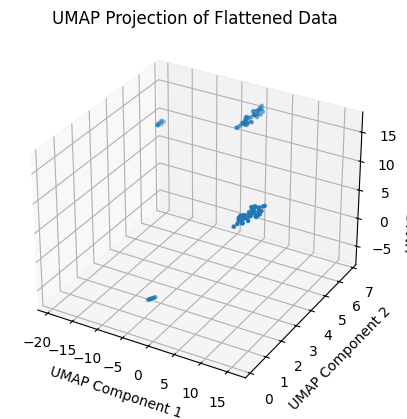

In [11]:
# 创建一个新的图形实例
fig = plt.figure()

# 添加一个三维坐标轴
ax = fig.add_subplot(111, projection='3d')

# 可视化结果
ax.scatter(best_embedding_1[:, 0], best_embedding_1[:, 1], best_embedding_1[:, 2], s=5)
ax.set_title('UMAP Projection of Flattened Data')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()

### 2. 3秒，全通道，θ波段
#### 1. 数据处理

In [12]:
# 数据预处理
data_reshaped_all_2 = np.zeros((0, 7776))
labels_all_2 = np.array([])
for i in range(1, 5):
    data_2 = OSPerson_dict[f'OSPerson{i}']['OS'][-21:-5, 4:13, :, :]

    # 首先使用transpose调整维度顺序
    data_transposed_2 = np.transpose(data_2, (2, 0, 1, 3))  # 将第三维（大小为40的维度）移到最前面
    # 然后将其余维度合并为一维
    data_reshaped_2 = data_transposed_2.reshape(data_transposed_2.shape[0], -1)  # 重塑数据为二维数组
    print(data_reshaped_2.shape)
    # 16x9x54 = 7776
    data_reshaped_all_2 = np.concatenate((data_reshaped_all_2, data_reshaped_2), axis=0)
    print(data_reshaped_all_2.shape)

(40, 7776)
(40, 7776)
(10, 7776)
(50, 7776)
(40, 7776)
(90, 7776)
(10, 7776)
(100, 7776)


#### 2. 流形学习
##### 1. 网格搜索最佳参数

In [23]:
param_grid_2 = {
    'n_neighbors': [10, 12, 15, 20, 22, 25], 
    'metric': ['euclidean']
}
best_params_2 = {}
best_score_2 = 0
for metric in param_grid_2['metric']:
    for n_neighbors in param_grid_2['n_neighbors']:
        print(f'test with n_neighbors: {n_neighbors}, metric: {metric}')
        # 初始化UMAP
        umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=3, metric=metric, random_state=None)
        # 拟合模型
        embedding = umap_model.fit_transform(data_reshaped_all_2)
        # 使用KMeans进行聚类
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(embedding)

        # 计算轮廓系数
        silhouette_avg = silhouette_score(embedding, labels)
        print("Silhouette Coefficient: ", silhouette_avg)

        # 计算戴维斯-布老德指数
        dbi = davies_bouldin_score(embedding, labels)
        print("Davies-Bouldin Index: ", dbi)

        # 计算Calinski-Harabasz指数
        ch = calinski_harabasz_score(embedding, labels)
        print("Calinski-Harabasz Index: ", ch)

        score = 1 / (1 + np.exp(-1 - silhouette_avg)) + 1 / (1 + np.exp(- dbi)) + 1 / (1 + np.exp(-ch))
        if score > best_score_2:
            best_score_2 = score
            best_params_2 = {'n_neighbors': n_neighbors, 'metric': metric}

print(f'best score: {best_score_2} with best params: {best_params_2}')


test with n_neighbors: 10, metric: euclidean
Silhouette Coefficient:  0.9286504
Davies-Bouldin Index:  0.06706029078417385
Calinski-Harabasz Index:  2831.0437573725685
test with n_neighbors: 12, metric: euclidean
Silhouette Coefficient:  0.83850205
Davies-Bouldin Index:  0.1500059148590391
Calinski-Harabasz Index:  563.5658304799092
test with n_neighbors: 15, metric: euclidean
Silhouette Coefficient:  0.75505495
Davies-Bouldin Index:  0.22654448375485137
Calinski-Harabasz Index:  244.25834635886883
test with n_neighbors: 20, metric: euclidean
Silhouette Coefficient:  0.724947
Davies-Bouldin Index:  0.2559537501820683
Calinski-Harabasz Index:  200.33107686307457
test with n_neighbors: 22, metric: euclidean
Silhouette Coefficient:  0.45918837
Davies-Bouldin Index:  0.8852334591110611
Calinski-Harabasz Index:  97.76563441522235
test with n_neighbors: 25, metric: euclidean
Silhouette Coefficient:  0.45398054
Davies-Bouldin Index:  0.879605095840708
Calinski-Harabasz Index:  98.005033761638

##### 2. 用最佳参数降维

In [24]:
best_best_score_2 = 0
for i in range(10):     
    # 初始化UMAP
    umap_model = umap.UMAP(n_neighbors=best_params_2['n_neighbors'], n_components=3, metric=best_params_2['metric'], random_state=None)
    # 拟合模型
    embedding = umap_model.fit_transform(data_reshaped_all_2)

    # 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(embedding)

    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, labels)
    print("Silhouette Coefficient: ", silhouette_avg)

    # 计算戴维斯-布老德指数
    dbi = davies_bouldin_score(embedding, labels)
    print("Davies-Bouldin Index: ", dbi)

    # 计算Calinski-Harabasz指数
    ch = calinski_harabasz_score(embedding, labels)
    print("Calinski-Harabasz Index: ", ch)

    score = 1 / (1 + np.exp(-1 - silhouette_avg)) + 1 / (1 + np.exp(- dbi)) + 1 / (1 + np.exp(-ch))
    if score > best_best_score_2:
        best_best_score_2 = score
        print(best_best_score_2)
        best_embedding_2 = embedding
print(f'the best best score: {best_best_score_2}')


Silhouette Coefficient:  0.46906126
Davies-Bouldin Index:  0.910402135227701
Calinski-Harabasz Index:  88.9890909411333
2.525997104561352
Silhouette Coefficient:  0.71646696
Davies-Bouldin Index:  0.26391353387007666
Calinski-Harabasz Index:  187.6163415405883
Silhouette Coefficient:  0.61871713
Davies-Bouldin Index:  0.3619802758800551
Calinski-Harabasz Index:  97.11108478264286
Silhouette Coefficient:  0.6849377
Davies-Bouldin Index:  0.2910251560771143
Calinski-Harabasz Index:  155.90754404161805
Silhouette Coefficient:  0.45803857
Davies-Bouldin Index:  0.8530926207049462
Calinski-Harabasz Index:  100.9297525274509
Silhouette Coefficient:  0.7656289
Davies-Bouldin Index:  0.21901591436333165
Calinski-Harabasz Index:  270.0848799140462
Silhouette Coefficient:  0.70205724
Davies-Bouldin Index:  0.2730252257508661
Calinski-Harabasz Index:  173.15017966848524
Silhouette Coefficient:  0.69282377
Davies-Bouldin Index:  0.2868168224866472
Calinski-Harabasz Index:  157.80353844556936
Silho

#### 3. 可视化

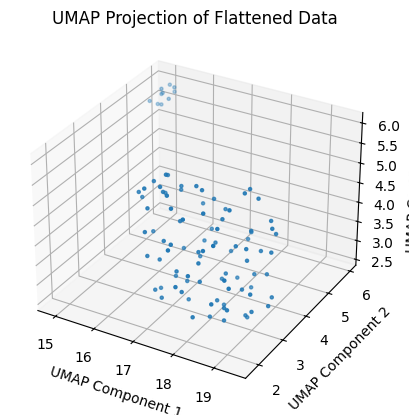

In [25]:
# 创建一个新的图形实例
fig = plt.figure()

# 添加一个三维坐标轴
ax = fig.add_subplot(111, projection='3d')

# 可视化结果
ax.scatter(best_embedding_2[:, 0], best_embedding_2[:, 1], best_embedding_2[:, 2], s=5)
ax.set_title('UMAP Projection of Flattened Data')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()